In [430]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [431]:
# Parameters
n = 5  # Grid size n x n
actions = ['up', 'right', 'down', 'left']  # Actions the agent can take
action_space = len(actions) # = 4

In [432]:
# Initialize Q-table: (agent_row, agent_col, package_row, package_col, carrying_flag, action) 
np.random.seed(222) # 222
q_values = np.random.rand(n, n, n, n, 2, action_space)

In [433]:
# Rewards
delivery_reward = 80  
move_reward = -1  
pickup_reward = 20 

In [434]:
# Define the target location (B)
B = (n - 1, n - 1)

In [435]:
# Function to check if the state is terminal (i.e., package delivered)
def is_terminal_state(agent_row, agent_col, carrying):
    return (agent_row, agent_col) == B and carrying

In [436]:
# Function to choose a random, non-terminal starting location for the agent and package
def get_starting_locations():
    agent_row = np.random.randint(n)
    agent_col = np.random.randint(n)
    package_row = np.random.randint(n)
    package_col = np.random.randint(n)

    return agent_row, agent_col, package_row, package_col

In [437]:
# Epsilon-greedy algorithm for choosing the next action
def get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon):
    if np.random.random() < epsilon:
        return np.argmax(q_values[agent_row, agent_col, package_row, package_col, carrying])
    else:
        return np.random.randint(action_space)

In [438]:
# Function to get the next location based on the chosen action
def get_next_location(agent_row, agent_col, action_index):
    new_row, new_col = agent_row, agent_col
    if actions[action_index] == 'up' and agent_row > 0:
        new_row -= 1
    elif actions[action_index] == 'right' and agent_col < n - 1:
        new_col += 1
    elif actions[action_index] == 'down' and agent_row < n - 1:
        new_row += 1
    elif actions[action_index] == 'left' and agent_col > 0:
        new_col -= 1
    return new_row, new_col

In [439]:
# Function to update the Q-values during training
#alpha - learning_rate, gamma - discount_factor
def update_q_values(old_state, action_index, reward, new_state, learning_rate, discount_factor, is_terminal_state):
    if not is_terminal_state:
        old_q_value = q_values[old_state][action_index]
        temporal_difference = reward + (discount_factor * np.max(q_values[new_state])) - old_q_value
        q_values[old_state][action_index] = old_q_value + (learning_rate * temporal_difference)
    else:
        old_q_value = q_values[old_state][action_index]
        temporal_difference = reward - old_q_value
        q_values[old_state][action_index] = old_q_value + (learning_rate * temporal_difference)

In [440]:
# Training parameters
epsilon = 0.9  # Epsilon for epsilon-greedy strategy
discount_factor = 0.9  # Discount factor for future rewards
learning_rate = 0.15  # Learning rate
num_episodes = 100000  # Number of training episodes
max_steps_per_episode = 100  # Limit the steps per episode

In [441]:
success_rates = []
episode_lengths = []
pickup_completion_rates = []
delivery_completion_rates = []

total_successes = 0
total_pickups = 0 # keeping track of the number of pickups
total_deliveries = 0 # keeping track of the number of successful deliveries
q_value_diffs = []  # For q value convergence

In [442]:
# Training loop
for episode in range(num_episodes):
    # Initialize starting locations
    agent_row, agent_col, package_row, package_col = get_starting_locations()
    carrying = 0  # Agent starts without carrying the package
    
    steps = 0 # keeping track of the number of steps for each episode
    
    old_q_values = np.copy(q_values) # For Q value convergence
    
    for step in range(max_steps_per_episode):
        # Choose action
        action_index = get_next_action(agent_row, agent_col, package_row, package_col, carrying, epsilon)
        epsilon += 0.000009
        # Get next location
        new_agent_row, new_agent_col = get_next_location(agent_row, agent_col, action_index)
        
        # Determine the reward and update carrying status
        if (new_agent_row, new_agent_col) == (package_row, package_col) and not carrying:
            reward = pickup_reward
            total_pickups += 1
            carrying = 1  # Now the agent is carrying the package
        elif (new_agent_row, new_agent_col) == B and carrying:
            reward = delivery_reward
            
        else:
            reward = move_reward
        
        # Update Q-values
        old_state = (agent_row, agent_col, package_row, package_col, carrying)
        new_state = (new_agent_row, new_agent_col, package_row, package_col, carrying)
        update_q_values(old_state, action_index, reward, new_state, learning_rate, discount_factor, is_terminal_state(agent_row, agent_col, carrying))
            
        steps += 1
        
        # Transition to the new state
        agent_row, agent_col = new_agent_row, new_agent_col
        
        # Check if the task is complete
        if is_terminal_state(agent_row, agent_col, carrying):
            total_successes += 1
            total_deliveries += 1
            break
            
    success_rate = total_successes / (episode + 1)
    success_rates.append(success_rate)
    episode_lengths.append(steps)
    
    # Task completion rates
    pickup_rate = total_pickups / (episode + 1)
    delivery_rate = total_deliveries / (episode + 1)
    pickup_completion_rates.append(pickup_rate)
    delivery_completion_rates.append(delivery_rate)
    
    # Q-value convergence
    q_value_diff = np.abs(q_values - old_q_values).sum()
    q_value_diffs.append(q_value_diff)
    
    

print('Training complete!')

Training complete!


# Model Evaluation

## Training

For evaluating our model during training, we are taking four metrics into account:

### 1. Success Rate over Episodes:
This determines the each time the agent successfully delivers the package to the location B per total episodes. 
$$
\text {Success Rate} = \frac{\text{Total Successes}}{\text{Total Episodes}}
$$

From the graph below, the model consistently achieves a success rate around 99% around the 30,000<sup>th</sup> episode.

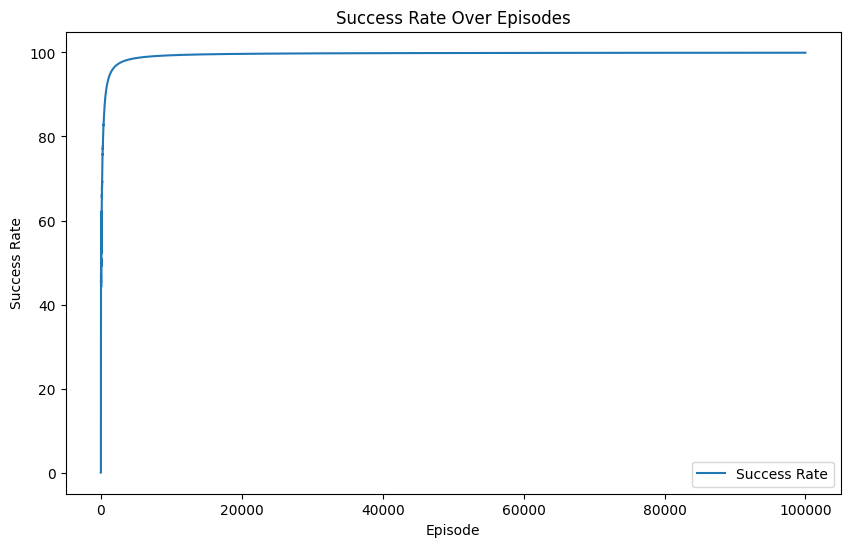

In [443]:
# Success Rate per total episodes
plt.figure(figsize=(10, 6))
plt.plot([rate*100 for rate in success_rates], label="Success Rate")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Success Rate Over Episodes")
plt.legend()
plt.show()

### 2. Episode Length

Episode length helps us to find the number of steps taken per episode to reach the goal state. The lesser number of steps taken, the more efficient the model is in reaching the goal.

From the graph below, we can see that there is a negative trend which stabilizes after the 20,000 epsiodes. The number of steps taken drastically reduces from 100 to 20 by 5000 episodes.

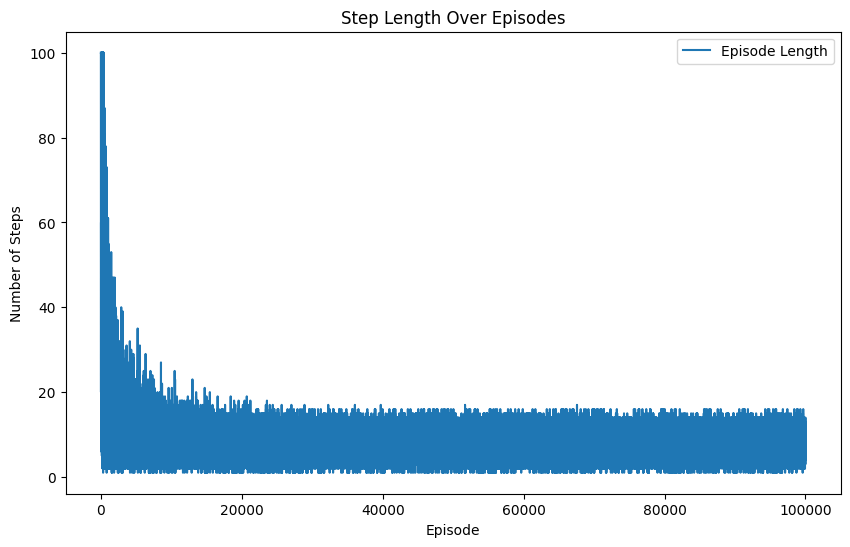

In [444]:
# No. of steps taken per episode
plt.figure(figsize=(10, 6))
plt.plot(episode_lengths, label="Episode Length")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")
plt.title("Step Length Over Episodes")
plt.legend()
plt.show()

### 3. Task Completion Rates

This metric measures the completion rates for whenever the agent pickups the package and for when it delivers it to B per total episodes.
$$
\text {Pickup Completion Rate} = \frac{\text{Total Pickups}}{\text{Total Episodes}}
$$

$$
\text {Delivery Completion Rate} = \frac{\text{Total Deliveries}}{\text{Total Episodes}}
$$

We can use this metric to find if the agent struggles with a particular task. From the graph the we see that agent learns to pickup the package first and then delivering it becomes it's priority.

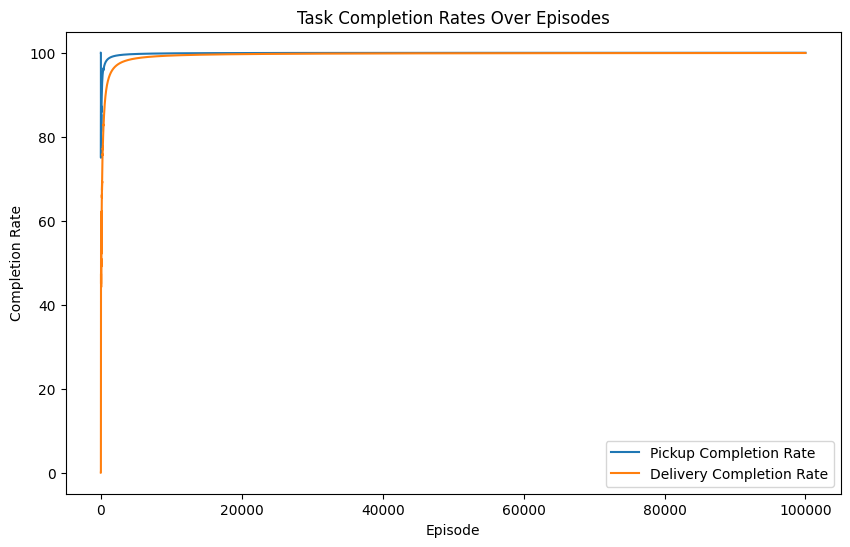

In [445]:
# Task Completion Rates for pickups and deliveries
plt.figure(figsize=(10, 6))
plt.plot([pickup*100 for pickup in pickup_completion_rates], label="Pickup Completion Rate")
plt.plot([delivery*100 for delivery in delivery_completion_rates], label="Delivery Completion Rate")
plt.xlabel("Episode")
plt.ylabel("Completion Rate")
plt.title("Task Completion Rates Over Episodes")
plt.legend()
plt.show()

### 4. Q-Value Convergence

This metric shows how efficiently our model is learning and finding the optimal path. It shows if the model converges where it has learned all it can possibly about the environment and the optimal path to the goal state.

We calculate convergence by finding the sum of the absolute difference between the old q values and the updated q values.

$$
\text {Q Value Convergence} = \text{sum(|old_q_values - new_q_values|)}
$$

From the graph below, we can see that the model converges at around 20,000 episodes maintaining a consistent rate of q values.

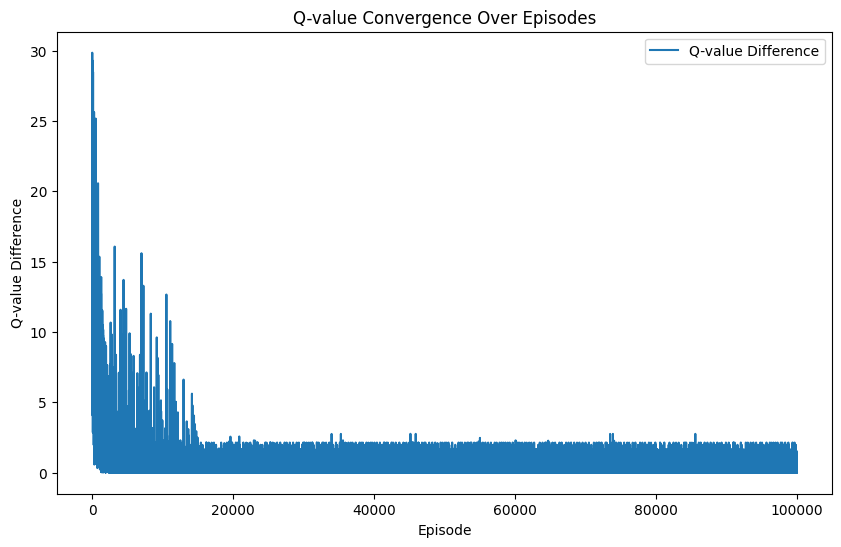

In [446]:
# Q-value Convergence
plt.figure(figsize=(10, 6))
plt.plot(q_value_diffs, label="Q-value Difference")
plt.xlabel("Episode")
plt.ylabel("Q-value Difference")
plt.title("Q-value Convergence Over Episodes")
plt.legend()
plt.show()

## Testing

We are testing the model for 1000 episodes independent of the location of A(the package). We also compare our model's path to the optimal path generated by A* algorithm with the heuristic of Manhattan distance. We are testing the success rate per total episodes and the optimal path rate per total episodes taken by the model.

Success rate here means the agent picks up the package and delivers it to B.

In [447]:
import networkx as nx

# Manhattan distance as the heuristic
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


# Test the agent's performance after training
def test_agent(num_tests=1000):
    success_count = 0
    # Create a grid for A*
    G = nx.grid_2d_graph(n, n)  # 5x5 grid
    no_optimal_paths = 0
    for _ in range(num_tests):
        agent_row, agent_col, package_row, package_col = get_starting_locations()
        
        # Finding the optimal path using A*
        start = (agent_row,agent_col)
        package = (package_row, package_col)
        goal = B
        opt_path_pkg = nx.astar_path(G, start, package, heuristic=heuristic)
        opt_path_goal = nx.astar_path(G, package, goal, heuristic=heuristic)
        
        # Testing the model
        carrying = 0
        path = [(agent_row, agent_col)]
        for step in range(max_steps_per_episode):
            action_index = get_next_action(agent_row, agent_col, package_row, package_col, carrying, 1.0)
            agent_row, agent_col = get_next_location(agent_row, agent_col, action_index)
            path.append((agent_row, agent_col))
            if (agent_row, agent_col) == (package_row, package_col) and not carrying:
                carrying = 1
            if is_terminal_state(agent_row, agent_col, carrying):
                success_count += 1
                break
                
        print(f'Path taken by agent for package location: {(package_row, package_col)} - ')
        print(path)
        
        # Finding how many optimal paths the model took compared to A*
        if len(path) == len(opt_path_pkg)+len(opt_path_goal)-1:
            no_optimal_paths+=1
            
    print(f'Success rate: {success_count}/{num_tests}')
    print(f'Optimal path rate: {no_optimal_paths}/{num_tests}')

test_agent()

Path taken by agent for package location: (2, 2) - 
[(0, 4), (0, 3), (0, 2), (1, 2), (2, 2), (3, 2), (3, 3), (3, 4), (4, 4)]
Path taken by agent for package location: (3, 1) - 
[(2, 2), (3, 2), (3, 1), (3, 2), (3, 3), (4, 3), (4, 4)]
Path taken by agent for package location: (1, 4) - 
[(0, 2), (0, 3), (1, 3), (1, 4), (2, 4), (2, 3), (3, 3), (4, 3), (4, 4)]
Path taken by agent for package location: (0, 0) - 
[(3, 4), (3, 3), (2, 3), (1, 3), (0, 3), (0, 2), (0, 1), (0, 0), (1, 0), (1, 1), (1, 2), (1, 3), (2, 3), (3, 3), (3, 4), (4, 4)]
Path taken by agent for package location: (1, 3) - 
[(2, 0), (2, 1), (1, 1), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (4, 4)]
Path taken by agent for package location: (4, 1) - 
[(1, 1), (2, 1), (3, 1), (4, 1), (4, 2), (4, 3), (4, 4)]
Path taken by agent for package location: (2, 0) - 
[(4, 3), (3, 3), (3, 2), (2, 2), (2, 1), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4)]
Path taken by agent for package location: (3, 1) - 
[(1, 4), (2, 4), (2, 3), 

The model has performed rather well with a success rate of 100%. Compared to A*, our model chooses the optimal path 91.3% for the 1000 episodes.